In [3]:
import scipy.optimize
import numpy as np 
import matplotlib.pyplot as plt
import scipy

In [4]:
import optimization
import oracles

In [5]:
np.random.seed(15)
m = 10
n = 2
A = np.random.uniform(size=(m,n))
b = np.random.uniform(size=(m))
X = [np.random.uniform((90, 100), size=(n)) for i in range(4)]
oracle = oracles.create_log_reg_oracle(A, b, 0.1)
grad_error = []
hess_error = []
for x in X:
    grad = oracle.grad(x)
    hess = oracle.hess(x)
    finite_grad = oracles.grad_finite_diff(oracle.func, x)
    finite_hess = oracles.hess_finite_diff(oracle.func, x)
    grad_error.append(scipy.linalg.norm(finite_grad - grad) / scipy.linalg.norm(grad))
    hess_error.append(scipy.linalg.norm(finite_hess - hess))

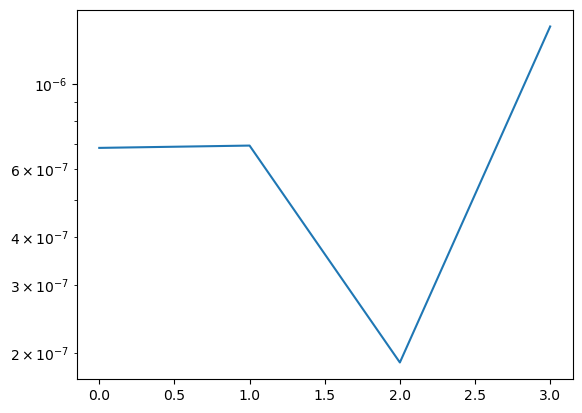

In [8]:
plt.semilogy(grad_error)
plt.show()

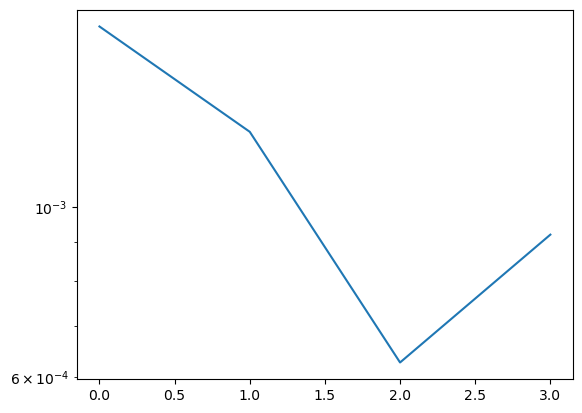

In [9]:
plt.semilogy(hess_error)
plt.show()

# 1. Траектория градиентного спуска

In [10]:
from oracles import QuadraticOracle
from plot_trajectory_2d import plot_levels
from plot_trajectory_2d import plot_trajectory
import numpy as np
import scipy
import matplotlib.pyplot as plt
from optimization import gradient_descent

In [11]:
A = np.array([[3, 0], [0, 2]])
b = np.ones(2)
x_1 = np.array([3, 3])
x_2 = np.array([5, 1])
oracle = QuadraticOracle(A, b)

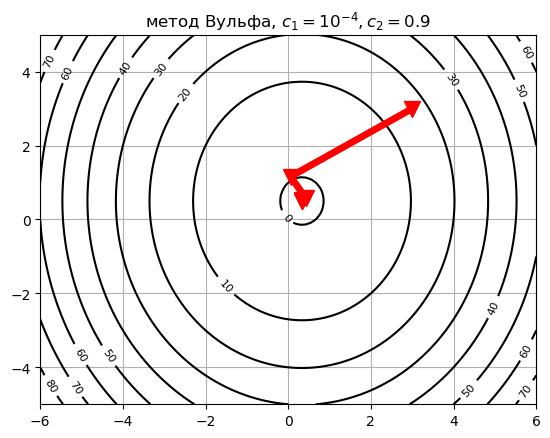

In [13]:
trace = gradient_descent(oracle, x_1, trace=True, line_search_options={'method' : 'Wolfe'})[2]['x']
plot_levels(oracle.func, levels=10)
plot_trajectory(oracle.func, trace)
plt.title('метод Вульфа, $c_1 = 10^{-4}, c_2 = 0.9$')
plt.show()

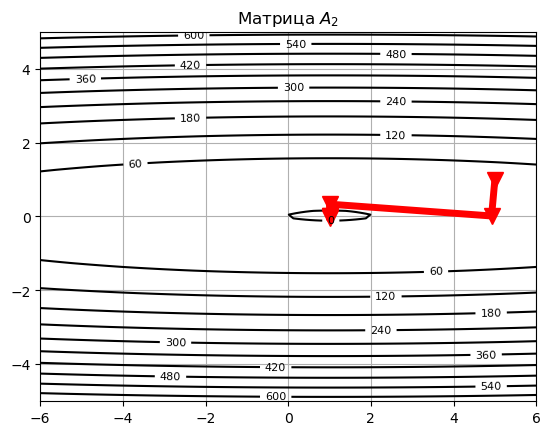

In [79]:
A2 = np.array([[1, 0], [0, 50]])
oracle2 = QuadraticOracle(A2, b)
trace = gradient_descent(oracle2, x_2, trace=True, line_search_options={'method' : 'Wolfe'})[2]['x']
plot_levels(oracle2.func, levels=10)
plot_trajectory(oracle2.func, trace)
plt.title(f'Матрица $A_2$')
plt.show()

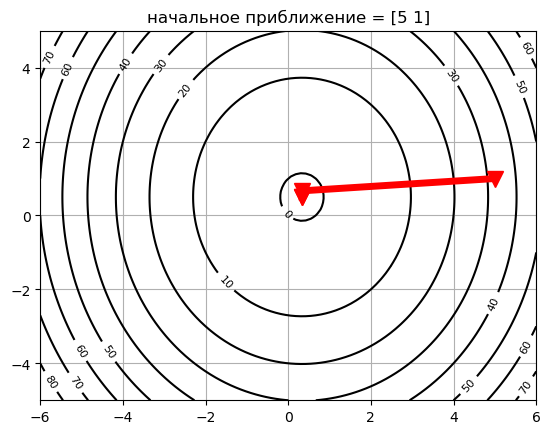

In [80]:
trace = gradient_descent(oracle, x_2, trace=True, line_search_options={'method' : 'Wolfe'})[2]['x']
plot_levels(oracle.func, levels=10)
plot_trajectory(oracle.func, trace)
plt.title(f'начальное приближение = {x_2}')
plt.show()

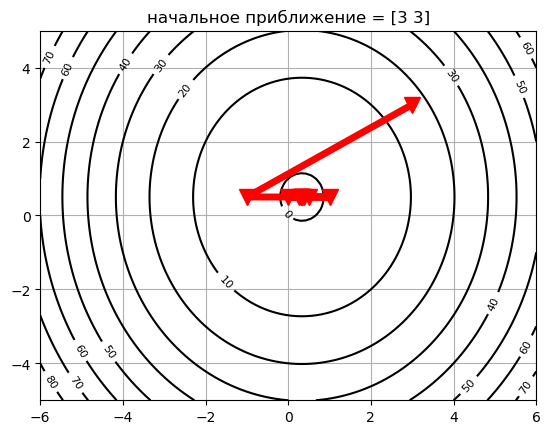

In [81]:
trace = gradient_descent(oracle, x_1, trace=True, line_search_options={'method' : 'Armijo'})[2]['x']
plot_levels(oracle.func,levels=10)
plt.title(f'начальное приближение = {x_1}')
plot_trajectory(oracle.func, trace)
plt.show()

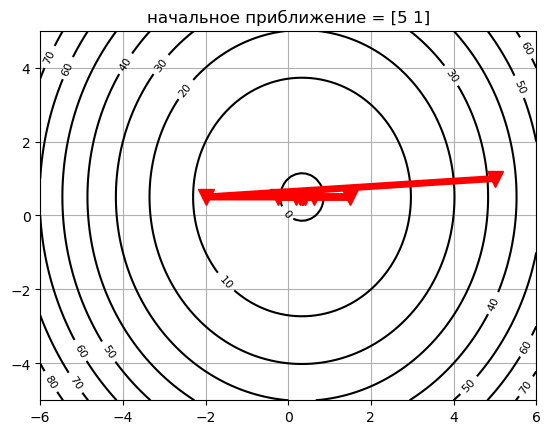

In [82]:
trace = gradient_descent(oracle, x_2, trace=True, line_search_options={'method' : 'Armijo'})[2]['x']
plot_levels(oracle.func,levels=10)
plt.title(f'начальное приближение = {x_2}')
plot_trajectory(oracle.func, trace)
plt.show()

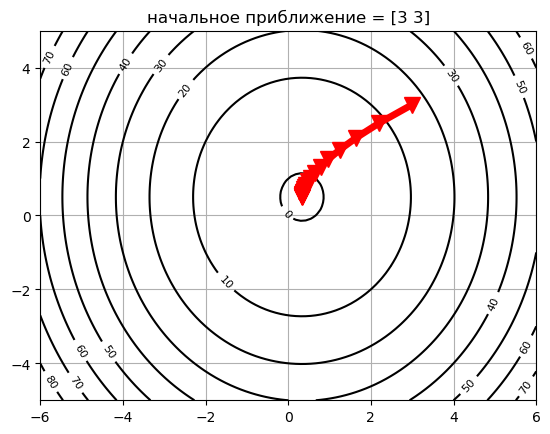

In [83]:
trace = gradient_descent(oracle, x_1, trace=True, line_search_options={'method' : 'Constant', 'c' : 0.1})[2]['x']
plot_levels(oracle.func, levels=10)
plot_trajectory(oracle.func, trace)
plt.title(f'начальное приближение = {x_1}')
plt.show()

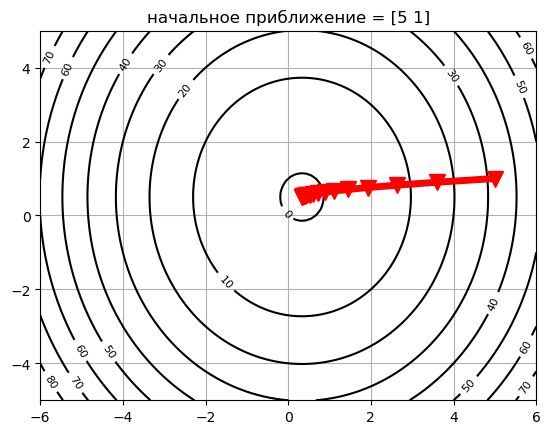

In [84]:
trace = gradient_descent(oracle, x_2, trace=True, line_search_options={'method' : 'Constant', 'c' : 0.1})[2]['x']
plot_levels(oracle.func, levels=10)
plot_trajectory(oracle.func, trace)
plt.title(f'начальное приближение = {x_2}')
plt.show()

# 2. Зависимость числа итераций градиентного спуска от числа обусловленности и размерности

In [54]:
def oracle_generator(k=1, n=2):
    if k == 1:
        diag = np.ones(n)
    else:
        diag = np.random.randint(1, k, size=n)
    diag[0] = 1
    diag[1] = k
    A = scipy.sparse.diags(diag)
    b = np.random.uniform(0, k, size=n)
    return QuadraticOracle(A, b)

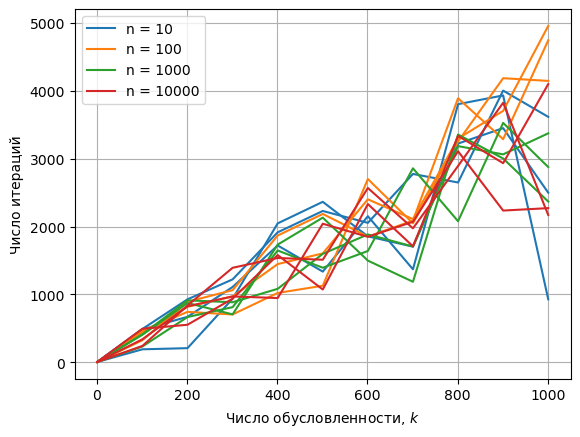

In [86]:
np.random.seed(42)
ns = np.logspace(1, 4, dtype=int, num=4)
n_exp = 3
ks = np.arange(1, 1002, 100)
T = np.zeros(len(ks))
for i in range(len(ns)):
    for j in range(n_exp):
        for k in range(len(ks)):
            x0 = np.ones(ns[i])
            oracle = oracle_generator(ks[k], ns[i])
            T[k] = len(gradient_descent(oracle, x0, trace=True, line_search_options = {'method' : 'Wolfe'},  tolerance=1e-10)[2]['func'])
        plt.plot(ks, T, label=f'n = {ns[i]}' if j == 0 else None, color=f'C{str(i)}' )
plt.xlabel('Число обусловленности, $k$')
plt.ylabel('Число итераций')
plt.legend()
plt.grid()
plt.show()

# 3.3 Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

In [14]:
from oracles import create_log_reg_oracle
from optimization import newton

In [2]:
from sklearn.datasets import load_svmlight_file

## w8a

In [56]:
X, y = load_svmlight_file('w8a.txt')

In [57]:
oracle = create_log_reg_oracle(X, y, regcoef=1/X.shape[1], oracle_type='optimized')
x0 = np.zeros(X.shape[1])

In [63]:
gradient_descent_result = gradient_descent(oracle, x0, trace=True, tolerance=1e-10)

In [64]:
newton_result = newton(oracle, x0, trace=True, tolerance=1e-10)

In [65]:
def plot_error_in_time(gd_results, newton_results, type='func'):
    gd_trace = gd_results[2]
    newton_trace = newton_results[2]
    if type == 'func':
        gd_f_start = gd_trace['func'][0]
        gd_f = gd_trace['func']
        gd_time = gd_trace['time']
        gd_f_opt = gd_trace['func'][-1]
        newton_f_start = newton_trace['func'][0]
        newton_f = newton_trace['func']
        newton_time = newton_trace['time']
        newton_f_opt = newton_trace['func'][-1]
        plt.semilogy(gd_time, np.abs((gd_f_opt - gd_f) / gd_f_start), label='градиентный спуск')
        plt.semilogy(newton_time, np.abs((newton_f_opt - newton_f) / newton_f_start), label='метод Ньютона')
        plt.title('Относительная ошибка по значению функции')
    if type == 'grad':
        gd_grad_start = gd_trace['grad_norm'][0]
        gd_time = gd_trace['time']
        gd_grad = np.array(gd_trace['grad_norm'])
        newton_grad_start = newton_trace['grad_norm'][0]
        newton_time = newton_trace['time']
        newton_grad = np.array(newton_trace['grad_norm'])
        plt.semilogy(gd_time, (gd_grad / gd_grad_start) ** 2, label='градиентный спуск')
        plt.semilogy(newton_time, (newton_grad / newton_grad_start) ** 2, label='метод Ньютона')
        plt.title('Относительная ошибка по норме градиента')

    plt.xlabel('Время, с')
    plt.ylabel('Относительная ошибка')
    plt.legend()
    plt.grid()

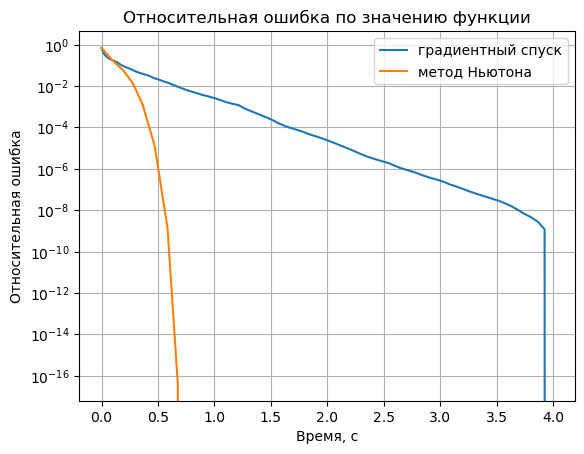

In [66]:
plot_error_in_time(gradient_descent_result, newton_result, type='func')
plt.show()

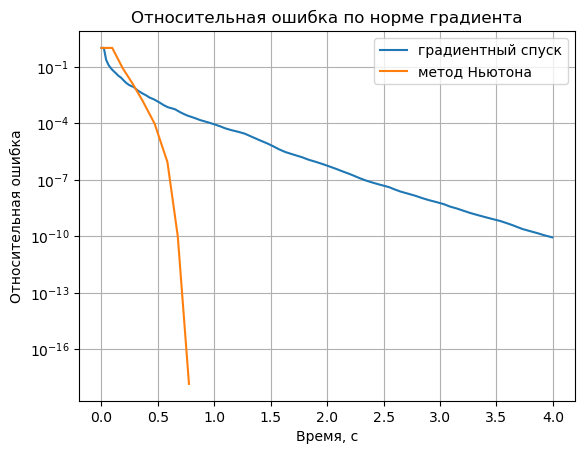

In [67]:
plot_error_in_time(gradient_descent_result, newton_result, type='grad')
plt.show()

## gisette

In [17]:
X_gisette, y_gisette = load_svmlight_file('gisette_scale.bz2')

In [18]:
oracle_gisette = create_log_reg_oracle(X_gisette, y_gisette, regcoef=1/X_gisette.shape[1], oracle_type='optimized')
x0_gisette = np.zeros(X_gisette.shape[1])

In [20]:
gradient_descent_gisette = gradient_descent(oracle_gisette, x0_gisette, trace=True, display=True)

Итерация: 0, время: 0.038102
Норма градиента: 2.5560888878044867
Итерация: 50, время: 35.072467
Норма градиента: 0.4225162775692068
Итерация: 100, время: 72.957473
Норма градиента: 0.2995054000118724
Итерация: 150, время: 108.087544
Норма градиента: 0.10606346576420984
Итерация: 200, время: 143.491137
Норма градиента: 0.1306413584092286
Итерация: 250, время: 177.658233
Норма градиента: 0.3010992980175871
Итерация: 300, время: 211.425799
Норма градиента: 0.10477255751486327
Итерация: 350, время: 246.656276
Норма градиента: 0.08543956809926076
Итерация: 400, время: 286.80567
Норма градиента: 0.07399691046801868
Итерация: 450, время: 322.398547
Норма градиента: 0.06259440321485576
Итерация: 500, время: 357.863743
Норма градиента: 0.05565330745394423
Итерация: 550, время: 395.849021
Норма градиента: 0.05016157873923025
Итерация: 600, время: 431.053747
Норма градиента: 0.045075194294153485
Итерация: 650, время: 467.913706
Норма градиента: 0.03940258166870848
Итерация: 700, время: 502.02799


In [19]:
newton_gisette = newton(oracle_gisette, x0_gisette, trace=True, display=True)

Итерация: 0, время: 0.039569
Норма градиента: 2.5560888878044867
Итерация: 1, время: 383.318745
Норма градиента: 2.5560888878044867
Итерация: 2, время: 765.887865
Норма градиента: 0.6200654449404246
Итерация: 3, время: 1164.533725
Норма градиента: 0.2204716466476844
Итерация: 4, время: 1557.543735
Норма градиента: 0.08181517516674854
Итерация: 5, время: 1945.456269
Норма градиента: 0.031217106930617022
Итерация: 6, время: 2341.340364
Норма градиента: 0.012315387981635503
Итерация: 7, время: 2716.719767
Норма градиента: 0.005087751800736161


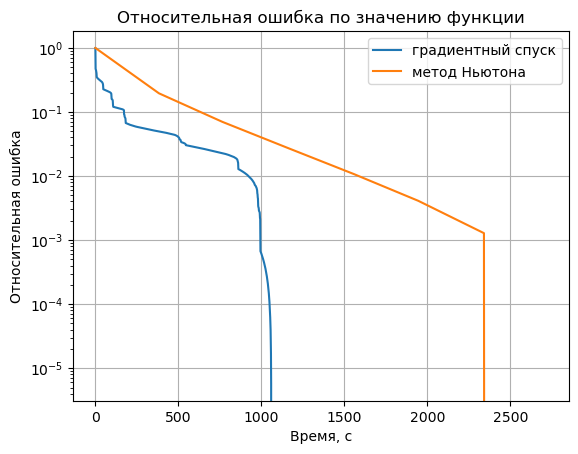

In [87]:
plot_error_in_time(gradient_descent_gisette, newton_gisette, type='func')
plt.show()

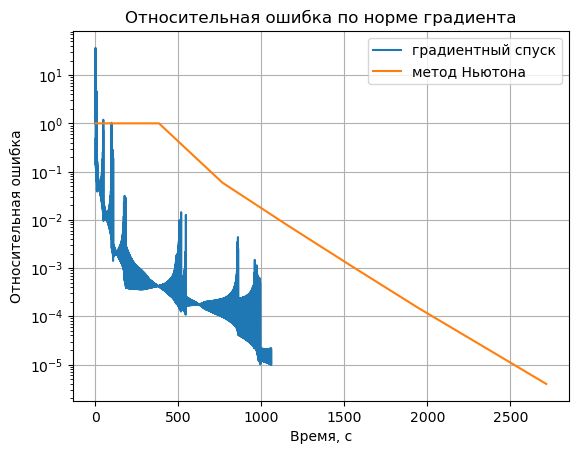

In [88]:
plot_error_in_time(gradient_descent_gisette, newton_gisette, type='grad')
plt.show()

# real-sim

In [68]:
X_realsim, y_realsim = load_svmlight_file('real-sim.bz2')

In [69]:
oracle_realsim = create_log_reg_oracle(X_realsim, y_realsim, regcoef=1/X_realsim.shape[1], oracle_type='optimized')
x0_realsim = np.zeros(X_realsim.shape[1])

In [71]:
gradient_descent_realsim = gradient_descent(oracle_realsim, x0_realsim, trace=True, tolerance=1e-10)

In [72]:
newton_realsim = newton(oracle_realsim, x0_realsim, trace=True, tolerance=1e-10)

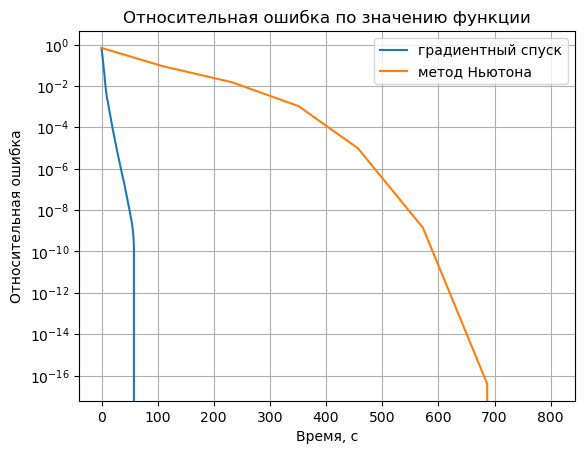

In [73]:
plot_error_in_time(gradient_descent_realsim, newton_realsim, type='func')
plt.show()

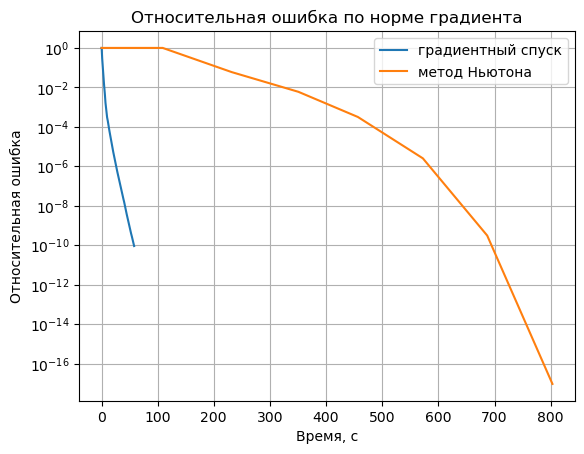

In [89]:
plot_error_in_time(gradient_descent_realsim, newton_realsim, type='grad')
plt.show()

# 3.4 Стратегия выбора длины шага в градиентном спуске

In [91]:
# Квадратичная функция:
np.random.seed(10)
sqr_oracle = oracle_generator(20,5)

In [92]:
def plot_relative_error(oracle, X0,type='func', line_search_options_grid = [{'method' : 'Armijo'}]):
    for options in line_search_options_grid:
        method = options.get('method', 'Wolfe')
        c = options.get('c', 1)
        c1 = options.get('c1', 1e-4)
        c2 = options.get('c2', 0.9)
        label = f'{method}, '
        if method == 'Constant':
            label += f'c = {c}'
        if method == 'Wolfe': 
            label += f'c1 = {c1}, c2 = {c2}'
        if method == 'Armijo':
            label += f'c1 = {c1}'
        x_opt, message, trace = gradient_descent(oracle, x0, trace=True, line_search_options=options)
        if type == 'func':
            f_start = oracle.func(x0)
            f_opt = oracle.func(x_opt)
            fs = trace['func']
            plt.semilogy(np.abs((fs - f_opt)/f_start), label = label)
        if type == 'grad':
            grad_start = trace['grad_norm'][0]
            grad = np.array(trace['grad_norm'])
            plt.semilogy((grad / grad_start) ** 2, label=label)
    plt.title(f'$x_0$ = {x0}')
    plt.ylabel('Относительная ошибка')
    plt.xlabel('Номер итерации')
    plt.legend()
    plt.grid()

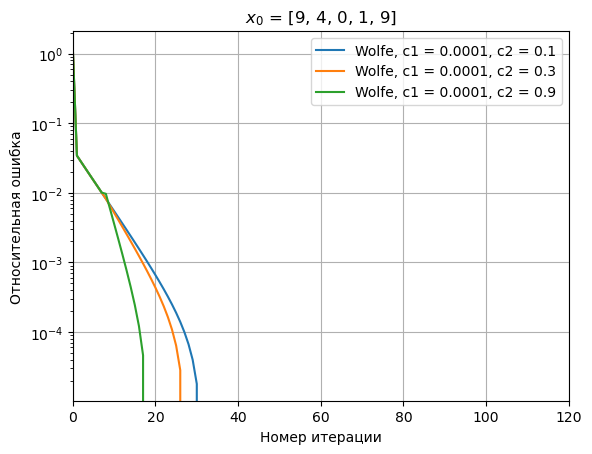

[9, 4, 0, 1, 9]


In [93]:
grid = [{'c2' : 0.1},
        {'c2' : 0.3},
        {'c2' : 0.9}
       ]
x0 = [9, 4, 0, 1, 9]
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0,120)
plt.show()
print(x0)

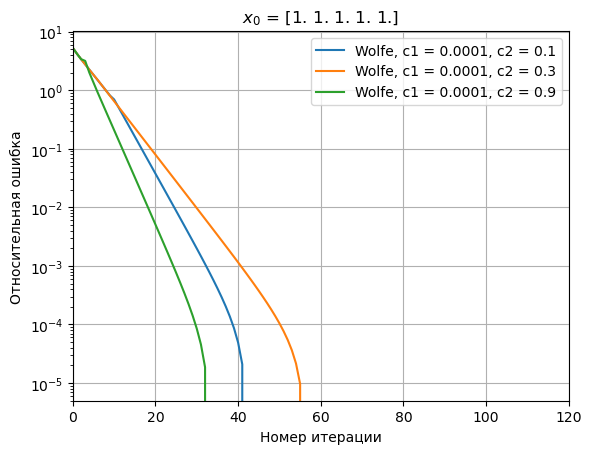

In [94]:
np.random.seed(10)
grid = [{'c2' : 0.1},
        {'c2' : 0.3},
        {'c2' : 0.9}
       ]
x0 = np.ones(5)
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0,120)
plt.show()

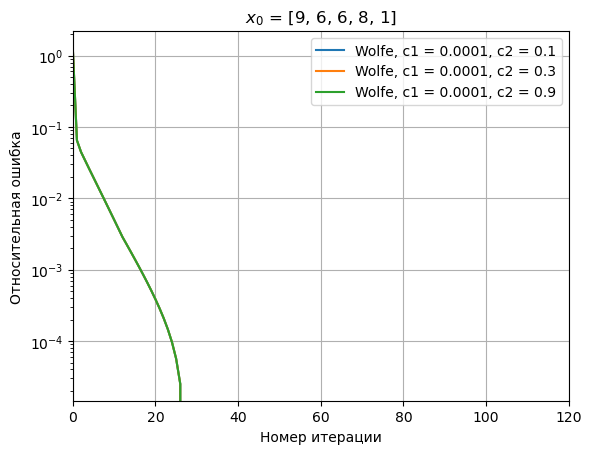

In [95]:
grid = [{'c2' : 0.1},
        {'c2' : 0.3},
        {'c2' : 0.9}
       ]
x0 = [9, 6, 6, 8, 1]
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0, 120)
plt.show()

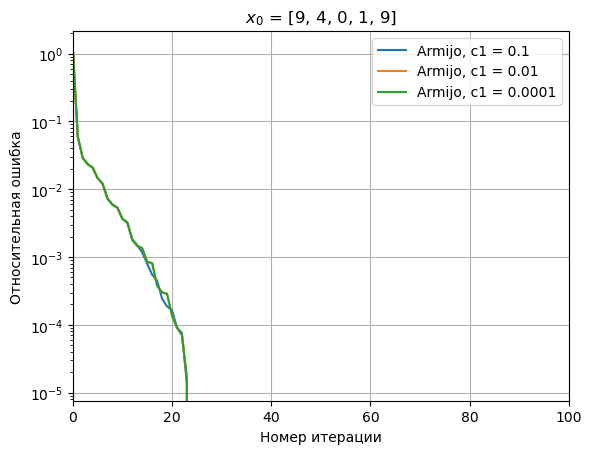

In [96]:
np.random.seed(10)
grid = [{'method' : 'Armijo', 'c1' : 0.1},
        {'method' : 'Armijo', 'c1' : 1e-2},
        {'method' : 'Armijo', 'c1' : 1e-4}
       ]
x0 = [9, 4, 0, 1, 9]
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0,100)
plt.show()

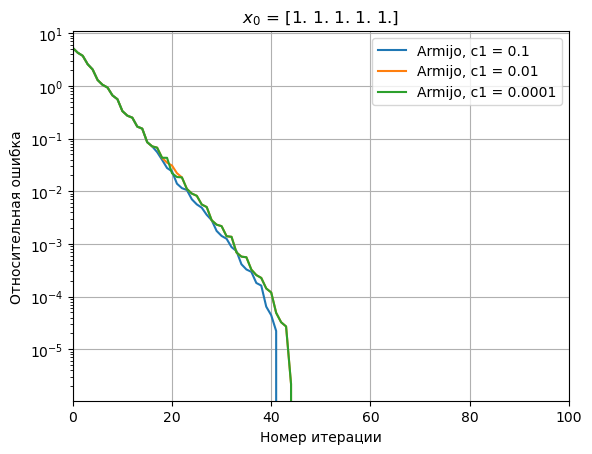

In [97]:
np.random.seed(10)
grid = [{'method' : 'Armijo', 'c1' : 0.1},
        {'method' : 'Armijo', 'c1' : 1e-2},
        {'method' : 'Armijo', 'c1' : 1e-4}
       ]
x0 = np.ones(5)
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0,100)
plt.show()

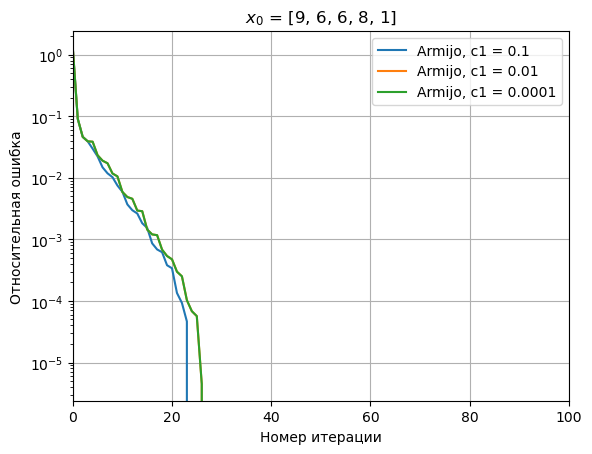

In [98]:
grid = [{'method' : 'Armijo', 'c1' : 0.1},
        {'method' : 'Armijo', 'c1' : 1e-2},
        {'method' : 'Armijo', 'c1' : 1e-4}
       ]
x0 = [9, 6, 6, 8, 1]
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0,100)
plt.show()

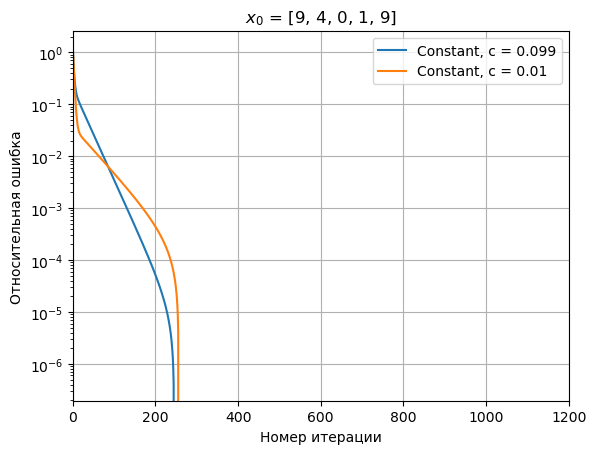

In [99]:
grid = [{'method' : 'Constant', 'c' : .99e-1},
        {'method' : 'Constant', 'c' : 1e-2}
       ]
x0 = [9, 4, 0, 1, 9]
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0, 1200)
plt.show()

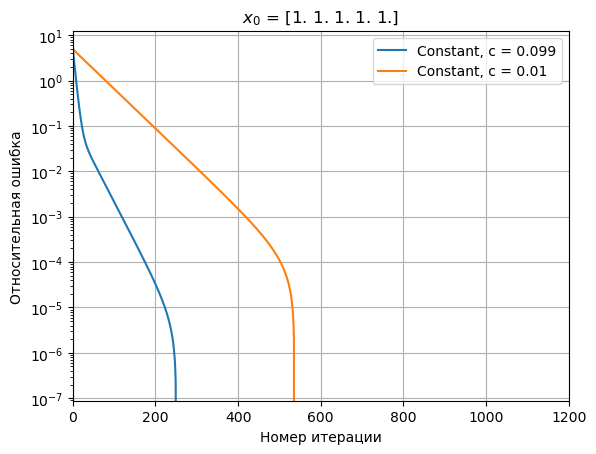

In [100]:
grid = [{'method' : 'Constant', 'c' : 0.99e-1},
        {'method' : 'Constant', 'c' : 1e-2}
       ]
x0 = np.ones(5)
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0, 1200)
plt.show()

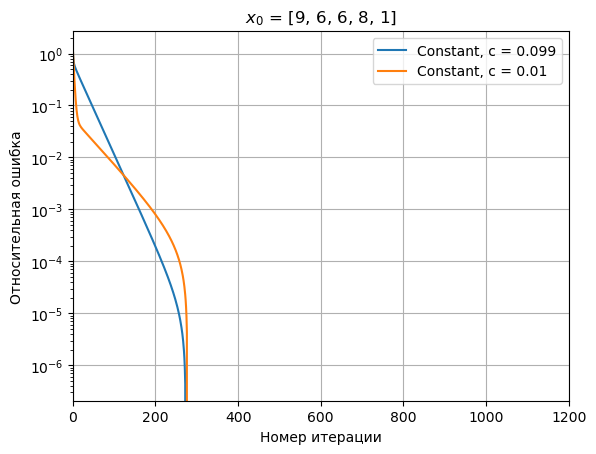

In [101]:
grid = [{'method' : 'Constant', 'c' : 0.99e-1},
        {'method' : 'Constant', 'c' : 1e-2}
       ]
x0 = [9, 6, 6, 8, 1]
plot_relative_error(sqr_oracle, x0, type='func', line_search_options_grid = grid)
plt.xlim(0,1200)
plt.show()

In [102]:
# Логистическая регресия
np.random.seed(10)
n = 10 
m = 20
A = np.random.uniform(0, 1, size=(m,n))
b = np.random.choice([-1,1],size=m)
oracle=create_log_reg_oracle(A,b,regcoef=1/m)
x0 =np.zeros(n)

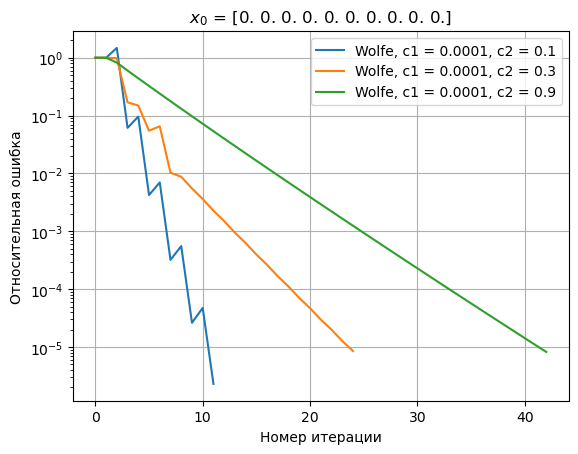

In [103]:
grid = [{'c2' : 0.1},
        {'c2' : 0.3},
        {'c2' : 0.9}
       ]
plot_relative_error(oracle, x0, type='grad', line_search_options_grid = grid)
plt.show()

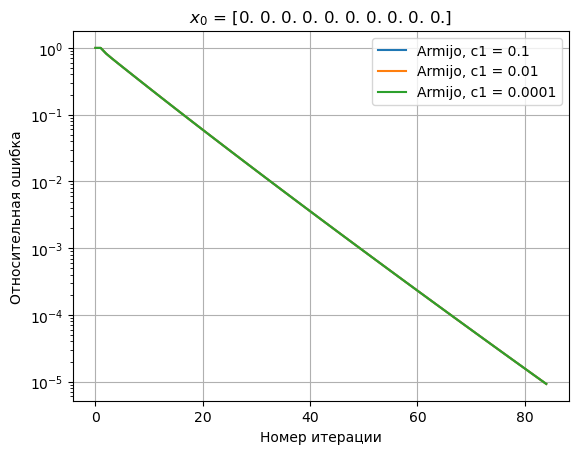

In [104]:
grid = [{'method' : 'Armijo', 'c1' : 0.1},
        {'method' : 'Armijo', 'c1' : 1e-2},
        {'method' : 'Armijo', 'c1' : 1e-4}
       ]
plot_relative_error(oracle, x0, type='grad', line_search_options_grid = grid)
plt.show()

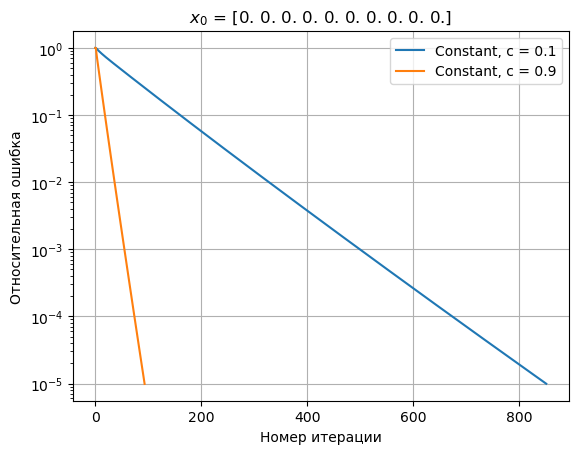

In [105]:
grid = [{'method' : 'Constant', 'c' : 0.1},
        {'method' : 'Constant', 'c' : 0.9}
       ]
plot_relative_error(oracle, x0, type='grad', line_search_options_grid = grid)
plt.show()

# 3.5 Стратегия выбора длины шага в методе Ньютона

In [106]:
# Логистическая регресия
np.random.seed(10)
n = 10 
m = 20
A = np.random.uniform(0, 1, size=(m,n))
b = np.random.choice([-1,1],size=m)
oracle=create_log_reg_oracle(A,b,regcoef=1/m)
x0 =np.zeros(n)

In [107]:
def plot_relative_error(oracle, X0,type='func', line_search_options_grid = [{'method' : 'Armijo'}]):
    for options in line_search_options_grid:
        method = options.get('method', 'Wolfe')
        c = options.get('c', 1)
        c1 = options.get('c1', 1e-4)
        c2 = options.get('c2', 0.9)
        label = f'{method}, '
        if method == 'Constant':
            label += f'c = {c}'
        if method == 'Wolfe': 
            label += f'c1 = {c1}, c2 = {c2}'
        if method == 'Armijo':
            label += f'c1 = {c1}'
        x_opt, message, trace = newton(oracle, x0, trace=True, line_search_options=options, tolerance=1e-10)
        if type == 'func':
            f_start = oracle.func(x0)
            f_opt = oracle.func(x_opt)
            fs = trace['func']
            plt.semilogy(np.abs((fs - f_opt)/f_start), label = label)
        if type == 'grad':
            grad_start = trace['grad_norm'][0]
            grad = np.array(trace['grad_norm'])
            plt.semilogy((grad / grad_start) ** 2, label=label)
    plt.title(f'$x_0$ = {x0}')
    plt.ylabel('Относительная ошибка')
    plt.xlabel('Номер итерации')
    plt.legend()
    plt.grid()

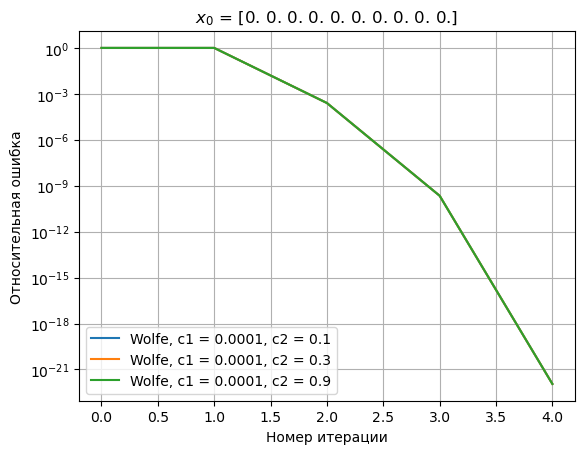

In [108]:
grid = [{'c2' : 0.1},
        {'c2' : 0.3},
        {'c2' : 0.9}
       ]
plot_relative_error(oracle, x0, type='grad', line_search_options_grid = grid)
plt.show()

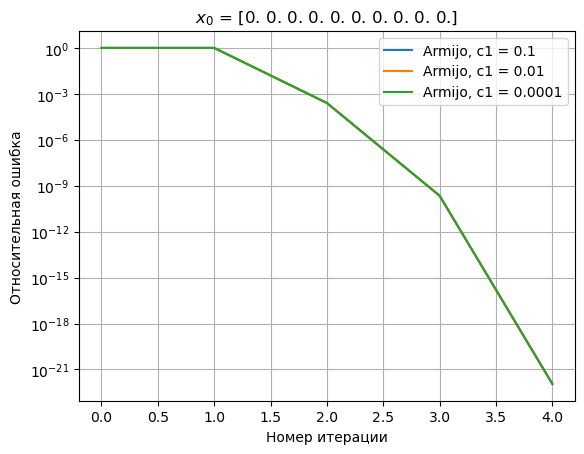

In [109]:
grid = [{'method' : 'Armijo', 'c1' : 0.1},
        {'method' : 'Armijo', 'c1' : 1e-2},
        {'method' : 'Armijo', 'c1' : 1e-4}
       ]
plot_relative_error(oracle, x0, type='grad', line_search_options_grid = grid)
plt.show()

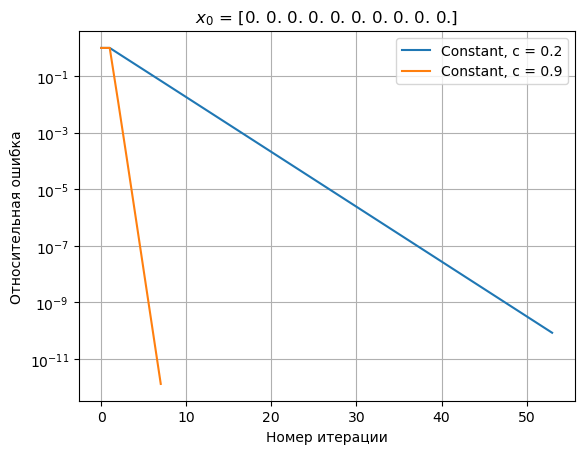

In [110]:
grid = [{'method' : 'Constant', 'c' : 0.2},
        {'method' : 'Constant', 'c' : 0.9}
       ]
plot_relative_error(oracle, x0, type='grad', line_search_options_grid = grid)
plt.show()